[View in Colaboratory](https://colab.research.google.com/github/SKhan97/Machine-Learning---Bootcamp/blob/master/Neural%20Networks.ipynb)

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
%matplotlib notebook
#Just use this magic function for when running in colab (doesn't support interactive mode)
%matplotlib inline 


import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

In [52]:
from google.colab import files
files.upload() #Cancer data
df = pd.read_csv('cancer_data.csv')
df[['diagnosis']] = df['diagnosis'].map({'M':1, 'B':0})
df = df.sample(frac=1)
df = df.drop('Unnamed: 32', axis=1) #Column of NaN values that have been removed
df.head()

Saving cancer_data.csv to cancer_data (2).csv


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
198,877486,1,19.18,22.49,127.50,1148.0,0.08523,0.14280,0.11140,0.06772,...,23.36,32.06,166.40,1688.0,0.1322,0.5601,0.3865,0.1708,0.3193,0.09221
87,86135502,1,19.02,24.59,122.00,1076.0,0.09029,0.12060,0.14680,0.08271,...,24.56,30.41,152.90,1623.0,0.1249,0.3206,0.5755,0.1956,0.3956,0.09288
465,9113239,0,13.24,20.13,86.87,542.9,0.08284,0.12230,0.10100,0.02833,...,15.44,25.50,115.00,733.5,0.1201,0.5646,0.6556,0.1357,0.2845,0.12490
89,861598,0,14.64,15.24,95.77,651.9,0.11320,0.13390,0.09966,0.07064,...,16.34,18.24,109.40,803.6,0.1277,0.3089,0.2604,0.1397,0.3151,0.08473
528,918192,0,13.94,13.17,90.31,594.2,0.12480,0.09755,0.10100,0.06615,...,14.62,15.38,94.52,653.3,0.1394,0.1364,0.1559,0.1015,0.2160,0.07253


In [0]:
X = torch.Tensor(np.array(df[df.columns[2:-1]]))
Y = torch.Tensor(np.array(df[['diagnosis']]))


In [0]:
m = 450
X =(X-X.mean(0))/X.std(0)

x_train = Variable(X[:m])
y_train = Variable(Y[:m])

x_test = Variable(X[m:-1])
y_test = Variable(Y[m:-1])

In [0]:
class Net(torch.nn.Module):
  
  def __init__(self):
    super().__init__()
    self.h1 = torch.nn.Linear(29,10) #29 features in the data
    self.out = torch.nn.Linear(10,1) #Output is only 1 because it is a classification problem
  
  def selu(self,x): #Selu function is like RELU but smoother since its not 0 for x < 0
    scale = 1.0507009873554804934193349852946
    alpha = 1.6732632423543772848170429916717
    x[x>0] = scale*x
    x[x<=0] = scale*(alpha*x.exp() - alpha)
    return x
  
  def forward(self,x):
    x = self.h1(x)
    x = F.selu(x)
    x = self.out(x)
    x = F.sigmoid(x)
    return x

In [0]:
epochs = 100
lr = 0.1
mynet = Net()
criterion = torch.nn.BCELoss()
optimiser = torch.optim.Rprop(mynet.parameters(),lr = lr)

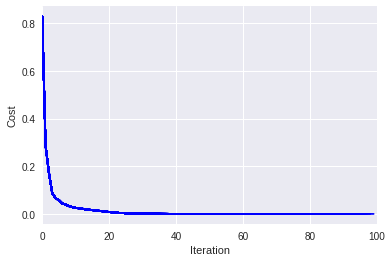

In [50]:
costs = []
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Iteration')
ax.set_ylabel('Cost')
ax.set_xlim(0,epochs)


def train(no_epochs):
  for epochs in range(no_epochs):
    h = mynet.forward(x_train)
    cost = criterion(h, y_train)
    costs.append(cost.data[0]) #Cost is the variable. cost.data is whats inside and the [0] is the first oe which we want
    ax.plot(costs, 'b')
    fig.canvas.draw()

    #print('Epoch', epochs, 'Cost', cost.data[0])
    
    optimiser.zero_grad()
    cost.backward()
    optimiser.step()

train(epochs)
plt.show()

In [51]:
test_h = mynet.forward(x_test)
test_h.data.round_()
correct = test_h.data.eq(y_test.data)
accuracy = torch.sum(correct)/correct.shape[0]
print('Test accuracy: ', accuracy)
torch.save(mynet.state_dict(), 'mynet_trained')

Test accuracy:  0.9745762711864406
